In [1]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [36]:
# Toy dataset: [x₁, x₂], label
data = [
    ([0.2, 0.4], 0),
    ([0.3, 0.4], 0),
    ([0.6, 0.5], 1),
    ([0.6, 0.7], 1)
]

In [30]:
# Define the VQC
def create_vqc(features, params):
    qc = QuantumCircuit(2, 1)  # 2 qubits, 1 classical bit
    # Data encoding
    qc.ry(features[0] * np.pi, 0)  # Scale x₁ to [0, π]
    qc.ry(features[1] * np.pi, 1)  # Scale x₂ to [0, π]
    # Ansatz
    qc.cx(0, 1)  # Entangle q0 (control) and q1 (target)
    qc.ry(params[0], 0)  # Variational parameter θ₁
    qc.ry(params[1], 1)  # Variational parameter θ₂
    # Measure qubit 0
    qc.measure(0, 0)
    return qc

In [31]:
# Simulate the circuit
def run_circuit(features, params, shots=1024):
    qc = create_vqc(features, params)
    simulator = AerSimulator()
    job = simulator.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()
    prob_0 = counts.get('0', 0) / shots  # P(|0⟩) for qubit 0
    prob_1 = counts.get('1', 1) / shots
    return prob_0, prob_1

In [32]:
# Cost function: Minimize difference between P(|0⟩) and target probability
def cost_function(params):
    total_cost = 0
    for features, label in data:
        prob_0, prob_1 = run_circuit(features, params)
        # Target: P(|0⟩) = 1 for label 0, P(|0⟩) = 0 for label 1
        target_prob = 1.0 if label == 0 else 0.0
        total_cost += (prob_0 - target_prob) ** 2
    return total_cost / len(data)  # Average cost

In [37]:
# Optimize
initial_params = [np.pi, np.pi]  # Start with non-zero values to force optimization
result = minimize(cost_function, initial_params, method='COBYLA', tol=1e-6)
optimal_params = result.x
print(f"Optimized parameters: θ₁ = {optimal_params[0]:.4f}, θ₂ = {optimal_params[1]:.4f}")
print(f"Final cost: {result.fun:.6f}")

Optimized parameters: θ₁ = 6.5496, θ₂ = 2.6566
Final cost: 0.063167


In [38]:
# Test the trained circuit
for features, label in data:
    prob_0 = run_circuit(features, optimal_params)
    prediction = 1 if prob_0 < 0.5 else 0
    print(f"Features: {features}, True Label: {label}, P(|0⟩): {prob_0:.4f}, Predicted: {prediction}")

Features: [0.2, 0.4], True Label: 0, P(|0⟩): 0.8262, Predicted: 0
Features: [0.3, 0.4], True Label: 0, P(|0⟩): 0.6758, Predicted: 0
Features: [0.6, 0.5], True Label: 1, P(|0⟩): 0.2178, Predicted: 1
Features: [0.6, 0.7], True Label: 1, P(|0⟩): 0.2549, Predicted: 1


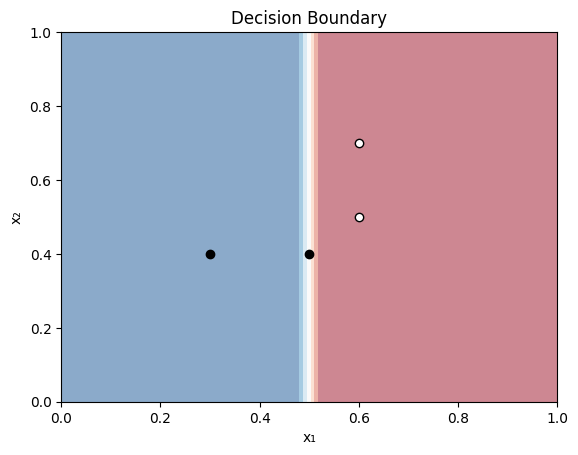

In [35]:
# Visualize decision boundary
def plot_decision_boundary(params):
    x = np.linspace(0, 1, 20)
    y = np.linspace(0, 1, 20)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            prob_0 = run_circuit([X[i, j], Y[i, j]], params)
            Z[i, j] = 0 if prob_0 > 0.5 else 1
    plt.contourf(X, Y, Z, cmap='RdBu', alpha=0.5)
    for features, label in data:
        plt.scatter(features[0], features[1], c='black' if label == 0 else 'white', edgecolors='k')
    plt.xlabel('x₁')
    plt.ylabel('x₂')
    plt.title('Decision Boundary')
    plt.show()

plot_decision_boundary(optimal_params)